In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
df = pd.read_csv('FRMIR_v1.csv',sep=';',parse_dates=['DateTime'],dayfirst=True)

In [3]:
df['Dates'] = df['DateTime'].dt.day_name() 
df['Time'] = df['DateTime'].dt.time

In [4]:
df

,DateTime,FOR_D,FOR_M,Power,Dates,Time
0,2020-03-05 00:00:00,1561.546745,14654.2,2398.581163,Thursday,00:00:00
1,2020-03-05 01:00:00,1308.262362,3982.0,2327.819766,Thursday,01:00:00
2,2020-03-05 02:00:00,1190.923118,3625.6,1587.336721,Thursday,02:00:00
3,2020-03-05 03:00:00,1697.768798,3269.2,1439.571654,Thursday,03:00:00
4,2020-03-05 04:00:00,1989.946882,3091.0,1375.600484,Thursday,04:00:00
...,...,...,...,...,...,...
2537,2020-07-24 22:00:00,378.737301,2734.6,1161.229859,Friday,22:00:00
2538,2020-07-24 23:00:00,611.716664,2080.1,1239.117910,Friday,23:00:00
2539,2020-07-25 00:00:00,614.771268,2378.2,1613.549091,Saturday,00:00:00
2540,2020-07-25 01:00:00,511.514462,2734.6,2200.139987,Saturday,01:00:00


In [9]:
df['Power']

0       2398.581163
1       2327.819766
2       1587.336721
3       1439.571654
4       1375.600484
           ...     
2537    1161.229859
2538    1239.117910
2539    1613.549091
2540    2200.139987
2541    2487.865467
Name: Power, Length: 2542, dtype: float64

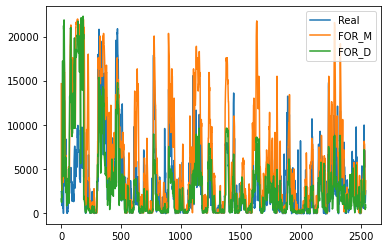

In [6]:
# Day+1
plt.figure('Day+1')

plt.plot(df['Power'],label='Real')
plt.plot(df['FOR_M'],label='FOR_M')
plt.plot(df['FOR_D'],label='FOR_D')
plt.legend()

---

Let’s come up with a simple idea and bound the performance.

AlgorithmRedefinew $k∈[0,1]$. We do weighted majority vote with weight updates. At eachround, apply $w_k←βw_k$ for all experts who made a mistake $(β∈(0,1))$.

1. Set $t= 1.$ Definew $k= 1$ for experts $k= 1..N.$

2. Predict $pt= 1$ if weighted average off $1,t,..,f_{N,t}$ is greater than 1/2, 0 otherwise.

3. ytreveals. Set $w_k←βw_k$ for those experts who made a mistake.

4. Increase $t←t+ 1$ Go to 2.

In [21]:
import numpy as np 
from numpy.linalg import norm 


In [84]:
def define_weight(true, agent_pred):
    w = np.zeros(len(true))

    distance_euclid = np.sqrt((true - agent_pred)**2) /  (true + agent_pred)
        
    for i in range(len(distance_euclid)):
        if distance_euclid[i] > 0.4:
            w[i] = 1
        else :
            w[i] = 0

    return np.mean(w)
    

In [85]:
w_for_D = define_weight(true = df['Power'], agent_pred = df['FOR_D'])
w_for_M = define_weight(true = df['Power'], agent_pred = df['FOR_M'])

Weighted Average Prediction :

$$
\widehat{p_t} = \frac{\sum_{i=1}^{N}w_{i,t-1}f_{i,t}}{\sum_{j=1}^{N}w_{j,t-1}}
$$

In [86]:
liste_agent = [df['FOR_D'], df['FOR_M']]
liste_weight = [w_for_D, w_for_M]

In [87]:
def WAP(liste_agent, liste_weight):
    
    pt = ( liste_weight[0] * liste_agent[0] + liste_weight[1] * liste_agent[1] ) / ( liste_weight[0] + liste_weight[1] ) 

    return pt

In [88]:
agent_WAP = WAP(liste_agent=liste_agent, liste_weight=liste_weight)

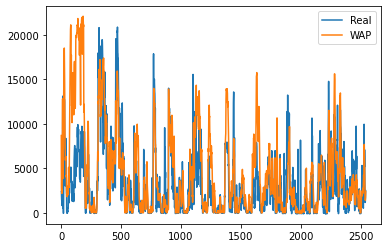

In [147]:
plt.plot(df['Power'],label='Real')
plt.plot(agent_WAP,label='WAP')
plt.legend()


#### The Exponentially Weighted Average Forecaster :

prediction de la fusion des agents :
$$
\widehat{p_t} = \frac{\sum_{i=1}^{N}w_{i,t-1}f_{i,t}}{\sum_{j=1}^{N}w_{j,t-1}}
$$

Weight with update (the weights are the exponential cumulative losses):
$$
w_{i,t}=w_{i, t-1}*\exp(-\eta*l(f_{i,t}y_{t}))
$$

In [673]:
def dist_eucl(value1, value2):
    return np.sqrt((value1 - value2)**2) /  (value1 + value2)

In [217]:
def EWAF(true, agent_pred_M, agent_pred_D, teta = 0.85):
    
    w_M = np.zeros(len(true))
    w_D = np.zeros(len(true))

    distance_euclid_M = dist_eucl(true, agent_pred_M)
    distance_euclid_D = dist_eucl(true, agent_pred_D)

    w_M[0] = 1
    w_D[0] = 1

    for i in range(len(true) - 1):
        w_M[i+1] = w_M[i]*np.exp(-teta * distance_euclid_M[i+1]) / (w_M[i] + w_D[i])
        w_D[i+1] = w_D[i]*np.exp(-teta * distance_euclid_D[i+1]) / (w_M[i] + w_D[i])

    return w_M, w_D

In [218]:
ewaf_for_M, ewaf_for_D = EWAF(true = df['Power'], agent_pred_M = df['FOR_M'], agent_pred_D = df['FOR_D'])


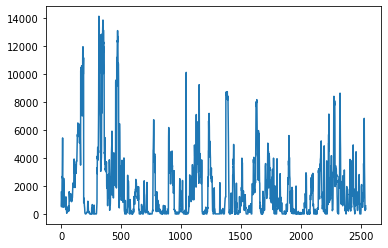

In [219]:
plt.plot(ewaf_for_D*df['FOR_D'])

In [220]:
ewaf_for_D 

array([1.        , 0.39396738, 0.43945899, ..., 0.68318675, 0.58900563,
       0.66501066])

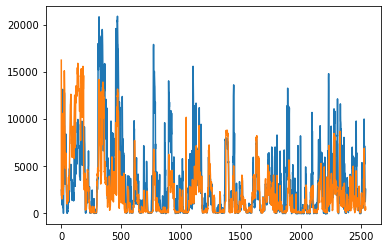

In [222]:
new = ewaf_for_M * df['FOR_M'] + ewaf_for_D*df['FOR_D']

plt.plot(df['Power'])
plt.plot(new)


In [228]:
dist_eucl(new, df['Power']).mean()

0.29924846933342875

In [216]:
df['FOR_M']

0       14654.2
1        3982.0
2        3625.6
3        3269.2
4        3091.0
         ...   
2537     2734.6
2538     2080.1
2539     2378.2
2540     2734.6
2541     3625.6
Name: FOR_M, Length: 2542, dtype: float64

In [203]:
ewaf_for_M * df['FOR_M'] + ewaf_for_D * df['FOR_D']

0       8107.873373
1       2575.526364
2       2331.367304
3       2405.829650
4       2450.565128
           ...     
2537     359.973544
2538     591.328038
2539     587.824406
2540     480.632513
2541     833.274870
Length: 2542, dtype: float64

In [204]:
ewaf_for_D * df['FOR_D']

0        780.773373
1        636.044109
2        586.490217
3        851.611863
4       1003.169061
           ...     
2537     359.973544
2538     591.328038
2539     587.824406
2540     480.632513
2541     833.274870
Name: FOR_D, Length: 2542, dtype: float64

In [205]:
df['FOR_D']

0       1561.546745
1       1308.262362
2       1190.923118
3       1697.768798
4       1989.946882
           ...     
2537     378.737301
2538     611.716664
2539     614.771268
2540     511.514462
2541     874.242626
Name: FOR_D, Length: 2542, dtype: float64

--

Polynomially Weighted Average Forecaster

$$
w_{i,t} = \sum_{s=1}^{t-1}(l(\widehat{p_t},y_s) - l(f_{i,s}, y_s))^{p-1}
$$

on normalise par 
$$
\sum_{j=1}^{N}(\sum_{s=1}^{t-1}(l(\widehat{p_t},y_s) - l(f_{j,s}, y_s)))^{p-1})
$$

In [683]:
def PWAF(true, agent_pred_M, agent_pred_D):
    
    pred = np.zeros(len(true))
    pred[0] = true[0]
    pred[1] = true[1]

    M_transi_M = np.zeros(len(true))

    M_transi_D = np.zeros(len(true))

    p = 2

    #regret cumulé
    R = np.zeros([len(true), 2])

    # regret instantanné
    r = np.zeros(2)

    # matrice Loss des agents
    l_M = dist_eucl(true, agent_pred_M)
    l_D = dist_eucl(true, agent_pred_D)

    # Matrice des agents (une ligne = un agent)
    M_A = (np.array([agent_pred_M, agent_pred_D]))


    for i in range(2, len(true)):
        r[0] = abs(dist_eucl(pred[i-1], true[i-1]) - l_M[i-1])
        r[1] = abs(dist_eucl(pred[i-1], true[i-1]) - l_D[i-1])

        R[i-1] = [r[0], r[1]]

        print(R.T[0])

        print(R.T[1])

        M_transi_M[i-1] = (np.sum(R.T[0]) )**(p-1)  
        M_transi_D[i-1] = (np.sum(R.T[1]) )**(p-1)

        pred[i] = ( ((np.sum(M_transi_M)) *  agent_pred_M[i-1]) + ((np.sum(M_transi_D)) * agent_pred_D[i-1]) ) /  ( (np.sum(M_transi_M))**(p-1) + (np.sum(M_transi_D))**(p-1) ) 


    print(M_transi_M)

    
    return pred

In [684]:
interogation = PWAF(true = df['Power'], agent_pred_M = df['FOR_M'], agent_pred_D = df['FOR_D'])

[0.         0.26215966 0.         ... 0.         0.         0.        ]
[0.         0.28039999 0.         ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.        ]
[0.         0.26215966 0.14912765 ... 0.         0.         0.        ]
[0.         0.28039999 0.09918918 ... 0.         0.         0.  

In [685]:
interogation

array([2398.58116329, 2327.81976567, 2600.18695055, ..., 1220.85299968,
       1346.32796251, 1433.79108549])

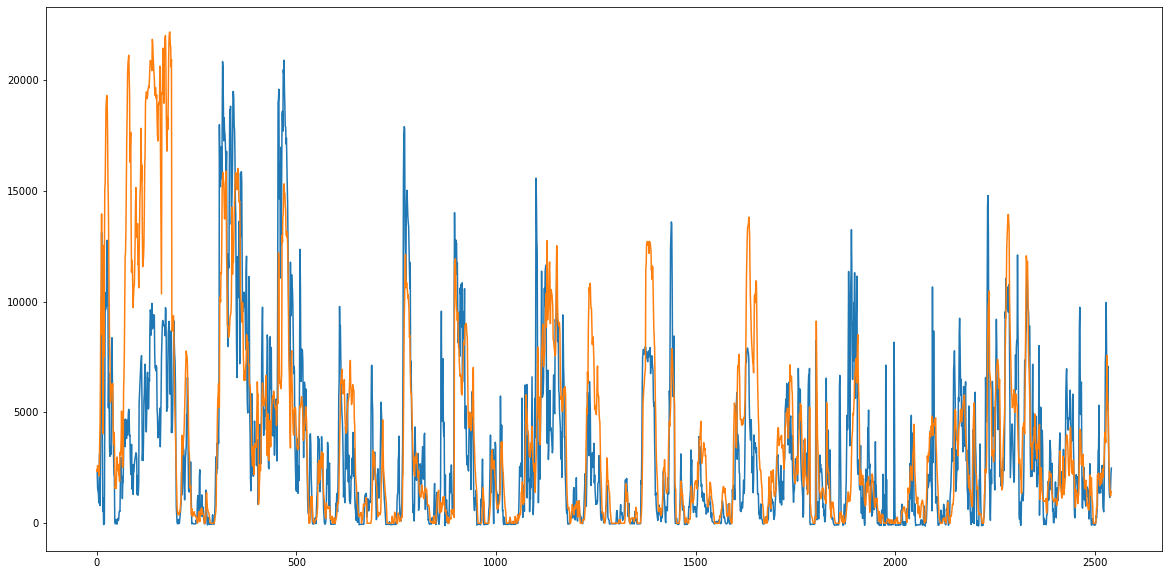

In [686]:
plt.figure(figsize=(20,10))
plt.plot(df['Power'])
plt.plot(interogation)

In [687]:
dist_eucl(interogation, df['Power']).mean()

0.4110210827460592

In [669]:
dist_eucl(df['FOR_M'], df['Power']).mean()

0.4239488371927807

In [670]:
dist_eucl(df['FOR_D'], df['Power']).mean()

0.3092070608240392